# TP Partie 1 : Génération de Dataset Synthétique pour le Fine-tuning de LLM

## 📚 Contexte

Dans ce notebook, nous allons explorer la génération de datasets d'instruction synthétiques, une technique clé pour créer des données d'entraînement pour le fine-tuning de modèles de langage. Cette approche permet de :

- **Créer des données d'entraînement** sans annotation manuelle coûteuse
- **Adapter un modèle** à des domaines spécifiques
- **Augmenter la diversité** des données existantes

## 🎯 Objectifs

1. **Comprendre** le processus de génération de données synthétiques
2. **Implémenter** une pipeline de génération basée sur des documents sources
3. **Créer** un dataset au format instruction-response utilisable pour le fine-tuning
4. **Analyser** la qualité et la diversité des données générées

## 🔧 Architecture

Notre approche s'inspire de la méthodologie AWS pour la génération de données synthétiques :

1. **Extraction de contexte** : Nous utilisons le corpus Common Corpus (split français)
2. **Génération de questions** : Un LLM génère des questions pertinentes basées sur le contexte
3. **Génération de réponses** : Le même ou un autre LLM génère des réponses aux questions
4. **Formatage** : Structuration au format instruction-suivie pour le fine-tuning

## ⚙️ Configuration

Nous utilisons :
- **vLLM** : Serveur d'inférence haute performance (déjà configuré sur votre machine)
- **Qwen3-4B** : Modèle de base pour la génération
- **Common Corpus** : Dataset source en français

## 1. Import des bibliothèques et configuration

In [25]:
import json
from typing import List, Dict, Optional, Tuple
from dataclasses import dataclass, asdict
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datasets import load_dataset
from openai import OpenAI
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed

# Configuration visuelle
sns.set_theme()
plt.rcParams['figure.figsize'] = (10, 6)

In [30]:
MODEL_NAME: str = "Qwen/Qwen3-4B-Instruct-2507"

## 2. Configuration du client vLLM

**Note importante** : Assurez-vous que votre serveur vLLM est lancé (`make vllm` dans un terminal séparé)

In [15]:
# Configuration du client OpenAI pour vLLM
client = OpenAI(
    base_url="http://51.159.189.97:8000/v1",
    api_key="ecn-llm-token-update-this-secret"  # Token défini dans start_vllm.sh
)

# Test de connexion
try:
    models = client.models.list()
    print("✅ Connexion au serveur vLLM réussie")
    print(f"Modèle disponible : {models.data[0].id if models.data else 'Aucun'}")
except Exception as e:
    print(f"❌ Erreur de connexion : {e}")
    print("Assurez-vous d'avoir lancé le serveur vLLM avec 'make vllm'")

✅ Connexion au serveur vLLM réussie
Modèle disponible : Qwen/Qwen3-4B-Instruct-2507


## 3. Chargement du dataset source

Nous utilisons le **Common Corpus** en français comme base pour générer nos instructions synthétiques.

In [4]:
# Chargement du dataset
print("Chargement du dataset Common Corpus (split français)...")
dataset = load_dataset(
    "PleIAs/common_corpus",
    split="train",
    streaming=True,  # Streaming pour économiser la mémoire
)

# Échantillonnage pour le TP (ajustez selon vos besoins)
SAMPLE_SIZE = 100  # Nombre de documents à traiter
documents = []

print(f"Extraction de {SAMPLE_SIZE} documents...")
for i, doc in enumerate(tqdm(dataset, total=SAMPLE_SIZE)):
    if i >= SAMPLE_SIZE:
        break
    # Filtrer les documents trop courts ou trop longs
    if doc.get('text') and 100 < len(doc['text']) < 2000:
        documents.append(doc['text'])

print(f"\n📊 Documents collectés : {len(documents)}")
print(f"Longueur moyenne : {np.mean([len(d) for d in documents]):.0f} caractères")

Chargement du dataset Common Corpus (split français)...


Resolving data files:   0%|          | 0/10011 [00:00<?, ?it/s]

Extraction de 100 documents...


  0%|          | 0/100 [00:00<?, ?it/s]


📊 Documents collectés : 36
Longueur moyenne : 691 caractères


## 4. Définition des structures de données

Nous utilisons des dataclasses pour structurer nos données de manière claire et typée.

In [26]:
@dataclass
class InstructionPair:
    """Structure pour une paire instruction-réponse"""
    instruction: str
    response: str
    context: str
    metadata: Dict = None
    
    def to_dict(self) -> Dict:
        return asdict(self)
    
    def to_alpaca_format(self) -> Dict:
        """Conversion au format Alpaca standard"""
        return {
            "instruction": self.instruction,
            "input": "",  # Contexte optionnel
            "output": self.response
        }

## 5. Pipeline de génération synthétique

### 5.1 Prompts pour la génération

Nous définissons des prompts soigneusement conçus pour générer des questions et réponses de qualité.

In [7]:
# Templates de prompts pour la génération
QUESTION_GENERATION_PROMPT = """Tu es un assistant pédagogique expert. À partir du texte suivant, génère une question pertinente en français.

La question doit :
- Être claire et précise
- Être directement basée sur le contenu du texte
- Être formulée en français correct
- Être adaptée pour un test de compréhension

Texte source :
{context}

Génère une seule question de haute qualité.
"""

ANSWER_GENERATION_PROMPT = """Tu es un assistant expert. Réponds à la question suivante de manière claire, précise et pédagogique en te basant sur le contexte fourni.

Contexte :
{context}

Question :
{question}

Réponse :
"""

### 5.2 Fonctions de génération

In [27]:
def generate_question(context: str) -> str:
    """
    Génère une question basée sur un contexte donné en utilisant structured output.
    
    Args:
        context: Le texte source
    
    Returns:
        Question générée
    """
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "Tu es un assistant qui génère des questions pédagogiques."},
                {"role": "user", "content": QUESTION_GENERATION_PROMPT.format(
                    context=context[:1500]  # Limiter la longueur du contexte
                )}
            ],
            temperature=0.7,
            max_tokens=200,
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "question_response",
                    "strict": True,
                    "schema": {
                        "type": "object",
                        "properties": {
                            "question": {
                                "type": "string",
                                "description": "La question générée basée sur le contexte"
                            }
                        },
                        "required": ["question"],
                        "additionalProperties": False
                    }
                }
            }
        )
        
        # Extraction de la question du JSON structuré
        content = response.choices[0].message.content
        import json
        result = json.loads(content)
        return result["question"]
        
    except Exception as e:
        print(f"Erreur lors de la génération de question : {e}")
        return "Quelle est l'idée principale de ce texte ?"


def generate_answer(context: str, question: str) -> str:
    """
    Génère une réponse à une question basée sur un contexte.
    
    Args:
        context: Le texte source
        question: La question à répondre
    
    Returns:
        Réponse générée
    """
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "Tu es un assistant expert qui répond de manière claire et pédagogique."},
                {"role": "user", "content": ANSWER_GENERATION_PROMPT.format(
                    context=context[:1500],
                    question=question
                )}
            ],
            temperature=0.3,  # Température plus basse pour des réponses cohérentes
            max_tokens=500
        )
        
        return response.choices[0].message.content.strip()
        
    except Exception as e:
        print(f"Erreur lors de la génération de réponse : {e}")
        return "Je ne peux pas répondre à cette question basée sur le contexte fourni."

### 5.3 Pipeline complète de génération

In [28]:
def process_single_document(doc: str) -> Optional[InstructionPair]:
    """
    Traite un seul document pour générer une paire instruction-réponse.
    
    Args:
        doc: Le document à traiter
    
    Returns:
        InstructionPair ou None si la génération échoue
    """
    try:
        # Créer un client local pour ce thread
        thread_client = OpenAI(
            base_url="http://51.159.189.97:8000/v1",
            api_key="ecn-llm-token-update-this-secret"
        )
        
        # Générer une seule question
        question = generate_question_with_client(thread_client, doc)
        
        if question and len(question) > 10:  # Filtre de qualité basique
            # Générer la réponse
            answer = generate_answer_with_client(thread_client, doc, question)
            
            if answer and len(answer) > 20:  # Filtre de qualité pour la réponse
                return InstructionPair(
                    instruction=question,
                    response=answer,
                    context=doc[:500],  # Garder un extrait du contexte
                    metadata={
                        "source": "common_corpus_fr",
                        "generation_method": "vllm_qwen3_4b_structured_concurrent"
                    }
                )
    except Exception as e:
        print(f"Erreur lors du traitement d'un document : {e}")
    
    return None


def generate_question_with_client(client: OpenAI, context: str) -> str:
    """
    Génère une question basée sur un contexte donné en utilisant structured output.
    
    Args:
        client: Le client OpenAI à utiliser
        context: Le texte source
    
    Returns:
        Question générée
    """
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "Tu es un assistant qui génère des questions pédagogiques."},
                {"role": "user", "content": QUESTION_GENERATION_PROMPT.format(
                    context=context[:1500]  # Limiter la longueur du contexte
                )}
            ],
            temperature=0.7,
            max_tokens=200,
            response_format={
                "type": "json_schema",
                "json_schema": {
                    "name": "question_response",
                    "strict": True,
                    "schema": {
                        "type": "object",
                        "properties": {
                            "question": {
                                "type": "string",
                                "description": "La question générée basée sur le contexte"
                            }
                        },
                        "required": ["question"],
                        "additionalProperties": False
                    }
                }
            }
        )
        
        # Extraction de la question du JSON structuré
        content = response.choices[0].message.content
        result = json.loads(content)
        return result["question"]
        
    except Exception as e:
        print(f"Erreur lors de la génération de question : {e}")
        return "Quelle est l'idée principale de ce texte ?"


def generate_answer_with_client(client: OpenAI, context: str, question: str) -> str:
    """
    Génère une réponse à une question basée sur un contexte.
    
    Args:
        client: Le client OpenAI à utiliser
        context: Le texte source
        question: La question à répondre
    
    Returns:
        Réponse générée
    """
    try:
        response = client.chat.completions.create(
            model=MODEL_NAME,
            messages=[
                {"role": "system", "content": "Tu es un assistant expert qui répond de manière claire et pédagogique."},
                {"role": "user", "content": ANSWER_GENERATION_PROMPT.format(
                    context=context[:1500],
                    question=question
                )}
            ],
            temperature=0.3,  # Température plus basse pour des réponses cohérentes
            max_tokens=500
        )
        
        return response.choices[0].message.content.strip()
        
    except Exception as e:
        print(f"Erreur lors de la génération de réponse : {e}")
        return "Je ne peux pas répondre à cette question basée sur le contexte fourni."


def generate_instruction_pairs(
    documents: List[str], 
    max_docs: Optional[int] = None,
    max_workers: int = 10
) -> List[InstructionPair]:
    """
    Génère des paires instruction-réponse à partir de documents avec des appels concurrents.
    
    Args:
        documents: Liste de documents sources
        max_docs: Nombre maximum de documents à traiter
        max_workers: Nombre maximum de workers concurrents (max 10)
    
    Returns:
        Liste de paires instruction-réponse
    """
    instruction_pairs = []
    docs_to_process = documents[:max_docs] if max_docs else documents
    
    # Limiter le nombre de workers à 10
    max_workers = min(max_workers, 10)
    
    print(f"🔄 Traitement concurrent avec {max_workers} workers...")
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Soumettre toutes les tâches
        future_to_doc = {
            executor.submit(process_single_document, doc): doc 
            for doc in docs_to_process
        }
        
        # Traiter les résultats au fur et à mesure
        with tqdm(total=len(docs_to_process), desc="Documents traités") as pbar:
            for future in as_completed(future_to_doc):
                try:
                    result = future.result()
                    if result:
                        instruction_pairs.append(result)
                except Exception as e:
                    print(f"Erreur lors du traitement : {e}")
                finally:
                    pbar.update(1)
    
    return instruction_pairs

## 6. Génération du dataset synthétique

**⚠️ Note** : Cette étape peut prendre plusieurs minutes selon le nombre de documents et la capacité de votre GPU.

In [31]:
# Paramètres de génération
NUM_DOCS_TO_PROCESS = 50  # Augmenté pour profiter du traitement concurrent
MAX_WORKERS = 10  # Nombre maximum de workers concurrents

print(f"🚀 Démarrage de la génération synthétique")
print(f"   - Documents à traiter : {NUM_DOCS_TO_PROCESS}")
print(f"   - Workers concurrents : {MAX_WORKERS}")
print(f"   - Questions par document : 1")
print(f"   - Paires attendues : ~{NUM_DOCS_TO_PROCESS}\n")

# Génération
synthetic_pairs = generate_instruction_pairs(
    documents,
    max_docs=NUM_DOCS_TO_PROCESS,
    max_workers=MAX_WORKERS
)

print(f"\n✅ Génération terminée : {len(synthetic_pairs)} paires créées")

🚀 Démarrage de la génération synthétique
   - Documents à traiter : 50
   - Workers concurrents : 10
   - Questions par document : 1
   - Paires attendues : ~50

🔄 Traitement concurrent avec 10 workers...


Documents traités:   0%|          | 0/36 [00:00<?, ?it/s]


✅ Génération terminée : 36 paires créées


## 7. Analyse et visualisation du dataset généré

In [32]:
# Conversion en DataFrame pour l'analyse
df = pd.DataFrame([pair.to_dict() for pair in synthetic_pairs])

# Statistiques de base
print("📊 Statistiques du dataset généré :")
print(f"   - Nombre total de paires : {len(df)}")
print(f"   - Longueur moyenne des instructions : {df['instruction'].str.len().mean():.0f} caractères")
print(f"   - Longueur moyenne des réponses : {df['response'].str.len().mean():.0f} caractères")

# Affichage d'exemples
print("\n📝 Exemples de paires générées :\n")
for i in range(min(3, len(synthetic_pairs))):
    print(f"--- Exemple {i+1} ---")
    print(f"Instruction : {synthetic_pairs[i].instruction}")
    print(f"Réponse : {synthetic_pairs[i].response[:200]}...\n")

📊 Statistiques du dataset généré :
   - Nombre total de paires : 36
   - Longueur moyenne des instructions : 108 caractères
   - Longueur moyenne des réponses : 882 caractères

📝 Exemples de paires générées :

--- Exemple 1 ---
Instruction : En quelle année a eu lieu la consultation de l'élection étatique de Katanning ?
Réponse : La consultation de l'élection étatique de Katanning a eu lieu en **1935**....

--- Exemple 2 ---
Instruction : Quel est le nom du catégory de Wikimedia qui regroupe les icefalls de la région de Ross Dependency ?
Réponse : Le nom du catégory de Wikimedia qui regroupe les icefalls de la région de Ross Dependency est **"Category:Icefalls of the Ross Dependency"**....

--- Exemple 3 ---
Instruction : Dans quel film Jean Pierre Melville évoque-t-il le dernier rôle de Bourvil, et en quelle année a été tourné ce film ?
Réponse : Jean Pierre Melville évoque le dernier rôle de Bourvil dans le film **"Le cercle rouge"**, qui a été **tourné en 1970**....



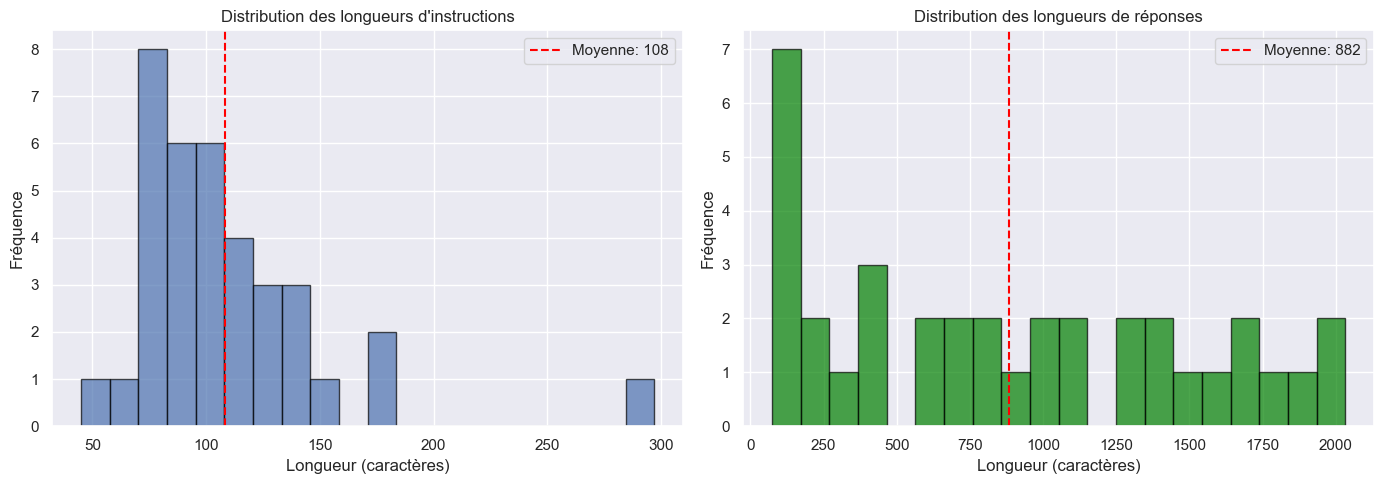

In [33]:
# Visualisations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution des longueurs d'instructions
axes[0].hist(df['instruction'].str.len(), bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Longueur (caractères)')
axes[0].set_ylabel('Fréquence')
axes[0].set_title('Distribution des longueurs d\'instructions')
axes[0].axvline(df['instruction'].str.len().mean(), color='red', 
                linestyle='--', label=f'Moyenne: {df["instruction"].str.len().mean():.0f}')
axes[0].legend()

# Distribution des longueurs de réponses
axes[1].hist(df['response'].str.len(), bins=20, edgecolor='black', alpha=0.7, color='green')
axes[1].set_xlabel('Longueur (caractères)')
axes[1].set_ylabel('Fréquence')
axes[1].set_title('Distribution des longueurs de réponses')
axes[1].axvline(df['response'].str.len().mean(), color='red', 
                linestyle='--', label=f'Moyenne: {df["response"].str.len().mean():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

## 8. Sauvegarde du dataset

Nous sauvegardons le dataset dans plusieurs formats pour faciliter son utilisation ultérieure.

In [34]:
import os
from pathlib import Path

# Création du dossier de sortie
output_dir = Path("../data/synthetic")
output_dir.mkdir(parents=True, exist_ok=True)

# Format Alpaca (standard pour le fine-tuning)
alpaca_data = [pair.to_alpaca_format() for pair in synthetic_pairs]
alpaca_path = output_dir / "synthetic_dataset_alpaca.json"
with open(alpaca_path, 'w', encoding='utf-8') as f:
    json.dump(alpaca_data, f, ensure_ascii=False, indent=2)
print(f"✅ Dataset au format Alpaca sauvegardé : {alpaca_path}")

# Format CSV pour l'analyse
csv_path = output_dir / "synthetic_dataset.csv"
df.to_csv(csv_path, index=False, encoding='utf-8')
print(f"✅ Dataset CSV sauvegardé : {csv_path}")

# Format JSONL (ligne par ligne, efficace pour le streaming)
jsonl_path = output_dir / "synthetic_dataset.jsonl"
with open(jsonl_path, 'w', encoding='utf-8') as f:
    for pair in synthetic_pairs:
        f.write(json.dumps(pair.to_dict(), ensure_ascii=False) + '\n')
print(f"✅ Dataset JSONL sauvegardé : {jsonl_path}")

✅ Dataset au format Alpaca sauvegardé : ../data/synthetic/synthetic_dataset_alpaca.json
✅ Dataset CSV sauvegardé : ../data/synthetic/synthetic_dataset.csv
✅ Dataset JSONL sauvegardé : ../data/synthetic/synthetic_dataset.jsonl


## 9. Contrôle qualité et filtrage

Il est important de vérifier la qualité des données générées avant de les utiliser pour le fine-tuning.

In [35]:
def quality_check(pair: InstructionPair) -> Tuple[bool, List[str]]:
    """
    Vérifie la qualité d'une paire instruction-réponse.
    
    Returns:
        (pass_check, list_of_issues)
    """
    issues = []
    
    # Vérifications de base
    if len(pair.instruction) < 10:
        issues.append("Instruction trop courte")
    if len(pair.response) < 20:
        issues.append("Réponse trop courte")
    if len(pair.instruction) > 500:
        issues.append("Instruction trop longue")
    if len(pair.response) > 1000:
        issues.append("Réponse trop longue")
    
    # Vérification de la présence de caractères spéciaux problématiques
    if any(char in pair.instruction + pair.response for char in ['\x00', '\r']):
        issues.append("Caractères spéciaux détectés")
    
    # Vérification de la cohérence
    if '?' not in pair.instruction:
        issues.append("L'instruction ne contient pas de question")
    
    return len(issues) == 0, issues

# Application du contrôle qualité
quality_results = []
for pair in synthetic_pairs:
    passed, issues = quality_check(pair)
    quality_results.append({
        'passed': passed,
        'issues': issues,
        'pair': pair
    })

# Statistiques de qualité
passed_count = sum(1 for r in quality_results if r['passed'])
print(f"📊 Résultats du contrôle qualité :")
print(f"   - Paires validées : {passed_count}/{len(quality_results)} ({100*passed_count/len(quality_results):.1f}%)")

# Affichage des problèmes les plus fréquents
all_issues = [issue for r in quality_results for issue in r['issues']]
if all_issues:
    from collections import Counter
    issue_counts = Counter(all_issues)
    print("\n🔍 Problèmes détectés :")
    for issue, count in issue_counts.most_common(5):
        print(f"   - {issue}: {count} occurrences")

📊 Résultats du contrôle qualité :
   - Paires validées : 21/36 (58.3%)

🔍 Problèmes détectés :
   - Réponse trop longue: 15 occurrences


In [36]:
# Sauvegarde du dataset filtré
filtered_pairs = [r['pair'] for r in quality_results if r['passed']]

if filtered_pairs:
    filtered_path = output_dir / "synthetic_dataset_filtered.json"
    with open(filtered_path, 'w', encoding='utf-8') as f:
        json.dump(
            [pair.to_alpaca_format() for pair in filtered_pairs],
            f,
            ensure_ascii=False,
            indent=2
        )
    print(f"\n✅ Dataset filtré sauvegardé : {filtered_path}")
    print(f"   Contient {len(filtered_pairs)} paires de haute qualité")


✅ Dataset filtré sauvegardé : ../data/synthetic/synthetic_dataset_filtered.json
   Contient 21 paires de haute qualité


## 10. Préparation pour le fine-tuning

### Recommandations pour l'étape suivante

Votre dataset synthétique est maintenant prêt pour le fine-tuning ! Voici quelques recommandations :

1. **Taille du dataset** : 
   - Minimum recommandé : 100-500 paires pour un fine-tuning basique
   - Idéal : 1000-5000 paires pour de meilleurs résultats

2. **Diversité** :
   - Variez les types de questions (factuelle, analytique, créative)
   - Utilisez différents domaines de contexte

3. **Qualité** :
   - Privilégiez la qualité à la quantité
   - Vérifiez manuellement un échantillon

4. **Format** :
   - Le format Alpaca est directement utilisable avec la plupart des frameworks
   - Gardez une trace du contexte original pour l'évaluation

In [37]:
# Résumé final
print("🎉 Génération de dataset synthétique terminée !\n")
print("📊 Résumé :")
print(f"   - Documents sources traités : {NUM_DOCS_TO_PROCESS}")
print(f"   - Paires générées : {len(synthetic_pairs)}")
print(f"   - Paires de haute qualité : {len(filtered_pairs) if filtered_pairs else 0}")
print(f"\n📁 Fichiers créés :")
print(f"   - {alpaca_path.name} (format Alpaca pour fine-tuning)")
print(f"   - {csv_path.name} (format CSV pour analyse)")
print(f"   - {jsonl_path.name} (format JSONL pour streaming)")
if filtered_pairs:
    print(f"   - {filtered_path.name} (dataset filtré)")

print("\n🚀 Prochaine étape : Notebook 02 - Fine-tuning avec LoRA")

🎉 Génération de dataset synthétique terminée !

📊 Résumé :
   - Documents sources traités : 50
   - Paires générées : 36
   - Paires de haute qualité : 21

📁 Fichiers créés :
   - synthetic_dataset_alpaca.json (format Alpaca pour fine-tuning)
   - synthetic_dataset.csv (format CSV pour analyse)
   - synthetic_dataset.jsonl (format JSONL pour streaming)
   - synthetic_dataset_filtered.json (dataset filtré)

🚀 Prochaine étape : Notebook 02 - Fine-tuning avec LoRA


## 📚 Pour aller plus loin

### Améliorations possibles

1. **Diversification des prompts** :
   - Créer plusieurs templates de prompts
   - Adapter les prompts selon le type de contenu

2. **Techniques avancées** :
   - Self-instruct : Utiliser le modèle pour générer ses propres instructions

3. **Validation** :
   - Utiliser un modèle différent pour valider les réponses
   - Implémenter un système de scoring
   - Cross-validation avec des annotateurs humains


### Exercices proposés

1. **Modifier les prompts** pour générer des instructions dans un domaine spécifique (médical, juridique, technique)
2. **Implémenter un système de scoring** pour évaluer automatiquement la qualité des paires
3. **Créer une pipeline de validation** avec le même modèle ou un second modèle (LLM as a judge)
4. **Expérimenter avec différentes températures** et analyser l'impact sur la diversité des contenus